In [ ]:
%reset

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image

In [2]:
DEBUG = False

base_path = "Data/CK:CK+/CK+"

img_data_path = "{}/cohn-kanade-images".format(base_path)
label_path = "{}/Emotion".format(base_path)
landm_path = "{}/Landmarks".format(base_path)

d = []
for root, dirs, files in os.walk(img_data_path):
    
    sorted_filtered_files = np.array(sorted(list(filter(lambda x: x.startswith('S'), files))))
    if len(sorted_filtered_files) < 1:
        continue
        
    ## Images
    neutral_expr_path = os.path.join(root,sorted_filtered_files[0])
    other_expression_path = os.path.join(root,sorted_filtered_files[-1])
    
    neutral_expr = np.asarray(Image.open(neutral_expr_path).convert('L').resize((128,98))).astype('float64') / 255
    other_expr = np.asarray(Image.open(other_expression_path).convert('L').resize((128,98))).astype('float64') / 255
    
    ## Landmarks 
    landmark_root = root.split("/")
    landmark_root[3] = "Landmarks"
    landmark_root = "/".join(landmark_root)
    
    landmark_neutral_file = "{}_landmarks.txt".format(sorted_filtered_files[0].split(".")[:-1][0])
    landmark_expr_file = "{}_landmarks.txt".format(sorted_filtered_files[-1].split(".")[:-1][0])
    
    neutral_expr_lm_path = os.path.join(landmark_root, landmark_neutral_file)
    other_expression_lm_path = os.path.join(landmark_root, landmark_expr_file)
    
    neutral_expr_lm = np.loadtxt(neutral_expr_lm_path)
    other_expression_lm = np.loadtxt(other_expression_lm_path)
    
    ## Labels
    splitted_file = sorted_filtered_files[0].split("_")
    subject = splitted_file[0]
        
    cur_labels_dir_path = os.path.join(label_path, splitted_file[0], splitted_file[1])

    if not os.path.isdir(cur_labels_dir_path):
        continue

    cur_labels_files = os.listdir(cur_labels_dir_path)
    if len(cur_labels_files) == 1:
        cur_labels_path = os.path.join(cur_labels_dir_path,cur_labels_files[0])
        if DEBUG: print("Label path: ",str(cur_labels_path))

        if os.path.exists(cur_labels_path):
            cur_label = int(np.loadtxt(cur_labels_path))

    if DEBUG: print("\tLabel: ",cur_label)
        
    ## TODO: !Expression! label to one hot encoding!
    d.append({"subject" : subject, 
              "neutral_expression": neutral_expr, 
              "other_expression": other_expr, 
              "neutral_lm" : neutral_expr_lm, 
              "expression_lm" : other_expression_lm,
              "label": cur_label})

data = pandas.DataFrame(d)

In [3]:
print(data.shape)
print(data.columns)

(582, 6)
Index(['expression_lm', 'label', 'neutral_expression', 'neutral_lm',
       'other_expression', 'subject'],
      dtype='object')


In [4]:
data.head(5)

,expression_lm,label,neutral_expression,neutral_lm,other_expression,subject
0,"[[186.7498, 194.23031], [187.05059, 225.50231]...",3,"[[0.0, 0.0, 0.00392156862745098, 0.00784313725...","[[186.58561, 194.22265], [186.86556, 225.52225...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",S111
1,"[[189.63074, 203.76777], [190.47364, 236.35196...",7,"[[0.011764705882352941, 0.01568627450980392, 0...","[[189.85019, 204.19275], [190.5603, 235.01057]...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",S111
2,"[[181.36249, 186.61609], [181.63523, 219.63695...",1,"[[0.0, 0.0, 0.0, 0.0, 0.01568627450980392, 0.0...","[[181.24777, 186.5473], [181.52682, 219.58782]...","[[0.011764705882352941, 0.00784313725490196, 0...",S111
3,"[[187.73892, 193.04935], [186.13858, 223.61771...",1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015686274509...","[[187.68237, 193.07485], [186.08427, 223.64936...","[[0.0, 0.0, 0.0, 0.0, 0.01568627450980392, 0.0...",S111
4,"[[184.38347, 190.64457], [184.77309, 220.98664...",1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[184.38165, 190.66961], [184.77276, 221.01358...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01...",S111


In [11]:
class Generator(nn.Module):
    
    def __init__(self, act_type, input_size,
                 hidden1_size, hidden2_size, hidden3_size, output_size):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden1_size, bias=True)
        self.layer2 = nn.Linear(hidden1_size, hidden2_size, bias=True)        
        self.layer3 = nn.Linear(hidden2_size, hidden3_size, bias=True)        
        self.layer4 = nn.Linear(hidden3_size, output_size, bias=True)
        
        self.activation = torch.relu if act_type == "relu" else torch.tanh

    def forward(self, x):
        
        z1 = self.activation(self.layer1(x));
        z2 = self.activation(self.layer2(z1));
        z3 = self.activation(self.layer3(z2));
        z4 = self.activation(self.layer4(z3));
        
        return z4

In [12]:
def bhook(module, grad_inp, grad_out):
    print(module, grad_inp, grad_out)

In [13]:
def train_net(net, num_iter, net_layers, train_data, train_label, bs=25, u=10e-2):
    
    losses = list()
    
    # make the criterion
    criterion = nn.MSELoss() # complete here

    # make the SGD optimizer. 
    optimizer=torch.optim.SGD(net.parameters(),lr=u)    
    
    prev = []
    for iter in range(1,num_iter+1):        
        # Set dL/dU, dL/dV, dL/dW to be filled with zeros
        optimizer.zero_grad()

        # create a minibatch
        indices=torch.LongTensor(bs).random_(0, train_data.size()[0])
        minibatch_data = train_data[indices, :]
        minibatch_label = train_label[indices]

        # reshape the minibatch
        inputs = minibatch_data.view(bs,net_layers[0]) 
    #     inputs = minibatch_data.view(train_data.size()[0], 28*28)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net
    #     print("#EPOCH", iter)
        net.cur_labels = minibatch_label
        scores = net (inputs)

        # Compute the average of the losses of the data points in the minibatch
#         print(minibatch_label.shape[1],scores.shape)
        loss = criterion(scores, minibatch_label.view(bs, minibatch_label.shape[1] * minibatch_label.shape[2]))

        # backward pass to compute dL/dU, dL/dV and dL/dW    
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        print("Epoch [{}/{}], Loss: {}".format(iter,num_iter,loss))
        losses.append(loss.item())

    return losses

In [14]:
num_pixels = 128 * 98
# n_in, n_h1, n_h2, n_out = num_pixels, num_pixels, num_pixels, num_pixels
net_layers = [num_pixels,num_pixels//2,num_pixels//4,num_pixels//2, num_pixels]
network = Generator('relu', *net_layers)

In [15]:
train_data = data.loc[:2328//2, "other_expression"]
train_label = data.loc[:2328//2, "neutral_expression"]
test_data = data.loc[2328//2: , "other_expression"]
test_label = data.loc[2328//2: , "neutral_expression"]

In [16]:
num_iter = 150
bs = 100
learning_rate = 10e-1
losses = train_net(network, num_iter, net_layers, torch.FloatTensor(train_data), torch.FloatTensor(train_label), bs, learning_rate)

Epoch [1/150], Loss: 0.22364982962608337
Epoch [2/150], Loss: 0.2130804806947708
Epoch [3/150], Loss: 0.21277505159378052
Epoch [4/150], Loss: 0.216671422123909
Epoch [5/150], Loss: 0.2111765593290329
Epoch [6/150], Loss: 0.19839541614055634
Epoch [7/150], Loss: 0.1844058334827423
Epoch [8/150], Loss: 0.18687403202056885
Epoch [9/150], Loss: 0.15908953547477722
Epoch [10/150], Loss: 0.1447010636329651
Epoch [11/150], Loss: 0.13666889071464539
Epoch [12/150], Loss: 0.12928901612758636
Epoch [13/150], Loss: 0.13146309554576874
Epoch [14/150], Loss: 0.12054992467164993
Epoch [15/150], Loss: 0.11972694098949432
Epoch [16/150], Loss: 0.12003360688686371
Epoch [17/150], Loss: 0.10916802287101746
Epoch [18/150], Loss: 0.11178331822156906
Epoch [19/150], Loss: 0.11934136599302292
Epoch [20/150], Loss: 0.1100708544254303
Epoch [21/150], Loss: 0.11001604795455933
Epoch [22/150], Loss: 0.1134614571928978
Epoch [23/150], Loss: 0.11656547337770462
Epoch [24/150], Loss: 0.12195667624473572
Epoch [25

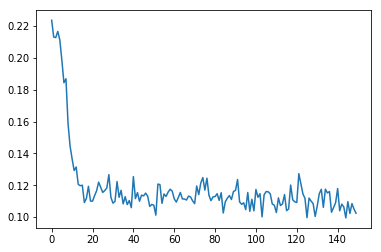

In [17]:
plt.plot(losses)

In [18]:
im_id = 99

In [19]:
predicted = network.forward(torch.FloatTensor(data.iloc[im_id]['other_expression']).view(98*128)).view(98,128)

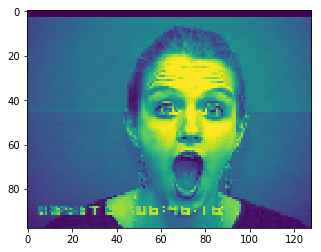

In [20]:
plt.imshow(data.iloc[im_id]['other_expression'])

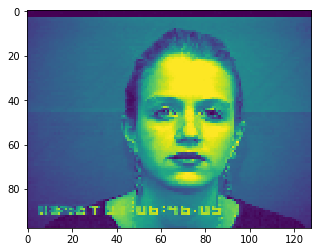

In [21]:
plt.imshow(data.iloc[im_id]['neutral_expression'])

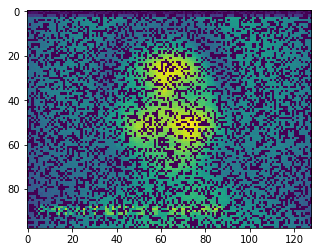

In [22]:
plt.imshow((predicted.detach().numpy()))

In [26]:
data.iloc[im_id]['neutral_expression'].shape

(98, 128)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
#         ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label